## 1. Setup & Imports

In [1]:
# Standard library
import os
import sys
import time
import json
import yaml
from pathlib import Path
from datetime import datetime

# Add src to path for imports
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")
print(f"Working directory: {Path.cwd()}")

# Data handling
import pandas as pd
import numpy as np
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("Imports successful!")
print(f"PyTorch version: {torch.__version__}")

Project root: /home/miguel/Desktop/MCIM/Projects/MCIM_Final_Project
Working directory: /home/miguel/Desktop/MCIM/Projects/MCIM_Final_Project/notebooks
Imports successful!
PyTorch version: 2.9.1+cu130


## 2. Configuration Loading

Load model and training configuration from YAML file.

In [2]:
# Load configuration with automatic type conversion
from src.utils import load_config

config_path = '../configs/model_config.yaml'
config = load_config(config_path)

print("Configuration loaded successfully!")
print("\n" + "="*70)
print("KEY CONFIGURATION")
print("="*70)

# Model config
print(f"\nModel Architecture:")
print(f"  Encoder: {config['model']['encoder']['architecture']}")
print(f"  Decoder: {config['model']['decoder']['type']}")
print(f"  Attention: {config['model']['decoder']['attention']['type']}")
print(f"  Embedding dim: {config['model']['decoder']['embedding_dim']}")
print(f"  Hidden dim: {config['model']['decoder']['hidden_dim']}")

# Training config
print(f"\nTraining Configuration:")
print(f"  Epochs: {config['training']['num_epochs']}")
print(f"  Batch size: {config['training']['batch_size']} (will auto-adjust)")
print(f"  Learning rate: {config['training']['optimizer']['learning_rate']}")
print(f"  Early stopping patience: {config['training']['early_stopping']['patience']}")

# Inference config
print(f"\nInference Configuration:")
print(f"  Method: {config['inference']['decoding']['method']}")
print(f"  Beam size: {config['inference']['decoding']['beam_size']}")
print(f"  Max length: {config['inference']['decoding']['max_length']}")

Configuration loaded successfully!

KEY CONFIGURATION

Model Architecture:
  Encoder: densenet121
  Decoder: lstm
  Attention: bahdanau
  Embedding dim: 512
  Hidden dim: 1024

Training Configuration:
  Epochs: 3
  Batch size: 32 (will auto-adjust)
  Learning rate: 0.0001
  Early stopping patience: 10

Inference Configuration:
  Method: beam_search
  Beam size: 3
  Max length: 50


## 3. Device Detection & Setup

Automatically detect and configure the best available device (CUDA/MPS/CPU).

In [3]:
# Import device utilities
from src.utils import get_device, get_device_info, print_device_info

# Detect device
device = get_device()
device_info = get_device_info()

# Print device information
print_device_info()

# Update configuration with device info
config['device'] = device_info

# Adjust batch size based on GPU memory
if device_info['device_type'] == 'cuda':
    gpu_memory_gb = device_info.get('memory_total_gb', 16)
    if gpu_memory_gb <= 4:
        config['training']['batch_size'] = 4
        config['training']['gradient_accumulation_steps'] = 8
        print("\nSmall GPU detected (4GB) - adjusted batch_size=4, gradient_accumulation=8")
    elif gpu_memory_gb <= 8:
        config['training']['batch_size'] = 16
        config['training']['gradient_accumulation_steps'] = 2
        print("\nMedium GPU detected (8GB) - adjusted batch_size=16, gradient_accumulation=2")
    else:
        config['training']['batch_size'] = 32
        print("\n✓ Large GPU detected (16GB+) - using batch_size=32")
elif device_info['device_type'] == 'mps':
    config['training']['batch_size'] = 16
    config['training']['mixed_precision'] = False
    print("\nMPS device - adjusted batch_size=16, disabled mixed precision")
else:
    config['training']['batch_size'] = 8
    config['training']['mixed_precision'] = False
    print("\nCPU device - adjusted batch_size=8, disabled mixed precision")
print(f"\nFinal batch size: {config['training']['batch_size']}")

Device Configuration
PyTorch version: 2.9.1+cu130
Device type: cuda
Device name: NVIDIA GeForce GTX 1650 Ti with Max-Q Design
CUDA version: 13.0
Device count: 1
Memory (total): 3.63 GB
Memory (available): 3.63 GB
Mixed precision support: True
Selected device: cuda

Recommended batch size: 8
  (Based on 3.6GB memory)

Small GPU detected (4GB) - adjusted batch_size=4, gradient_accumulation=8

Final batch size: 4


## 4. Data Loading

Load preprocessed data splits and create PyTorch Datasets and DataLoaders.

In [4]:
# Import data utilities
from src.data import Vocabulary, get_transforms, ChestXrayDataset, collate_fn

# Paths (relative to project root)
preprocessing_variant = config['paths']['preprocessing_variant']
processed_dir = project_root / config['paths']['processed_dir'] / preprocessing_variant

vocab_file = processed_dir / 'vocabulary.txt'
train_csv = processed_dir / 'train.csv'
val_csv = processed_dir / 'val.csv'
test_csv = processed_dir / 'test.csv'
image_dir = project_root / config['paths']['images_dir']

# Verify files exist
for path in [vocab_file, train_csv, val_csv, test_csv, image_dir]:
    if not path.exists():
        raise FileNotFoundError(f"Required file not found: {path}")

print("✓ All data files found")

# Load vocabulary
print("\nLoading vocabulary...")
vocabulary = Vocabulary(str(vocab_file))
print(f"✓ Vocabulary loaded: {len(vocabulary)} tokens")

# Update config with vocab size
config['model']['decoder']['vocab_size'] = len(vocabulary)

# Create transforms
print("\nCreating image transforms...")
train_transform = get_transforms(
    image_size=config['data']['image_size'],
    mode='train',
    normalize_mean=config['data']['normalize']['mean'],
    normalize_std=config['data']['normalize']['std'],
    rotation_degrees=config['data']['augmentation']['random_rotation_degrees'],
    color_jitter=config['data']['augmentation']['color_jitter']
)

val_transform = get_transforms(
    image_size=config['data']['image_size'],
    mode='val',
    normalize_mean=config['data']['normalize']['mean'],
    normalize_std=config['data']['normalize']['std']
)

print("✓ Transforms created")

✓ All data files found

Loading vocabulary...
✓ Vocabulary loaded: 514 tokens

Creating image transforms...
✓ Transforms created


In [5]:
# Create datasets
print("\nCreating datasets...")

train_dataset = ChestXrayDataset(
    csv_file=str(train_csv),
    image_dir=str(image_dir),
    vocabulary=vocabulary,
    transform=train_transform,
    max_caption_length=config['data']['max_caption_length']
)

val_dataset = ChestXrayDataset(
    csv_file=str(val_csv),
    image_dir=str(image_dir),
    vocabulary=vocabulary,
    transform=val_transform,
    max_caption_length=config['data']['max_caption_length']
)

test_dataset = ChestXrayDataset(
    csv_file=str(test_csv),
    image_dir=str(image_dir),
    vocabulary=vocabulary,
    transform=val_transform,
    max_caption_length=config['data']['max_caption_length']
)

print(f"✓ Datasets created:")
print(f"    Training: {len(train_dataset)} samples")
print(f"    Validation: {len(val_dataset)} samples")
print(f"    Test: {len(test_dataset)} samples")

# Create dataloaders
print("\nCreating dataloaders...")

train_loader = DataLoader(
    train_dataset,
    batch_size=config['training']['batch_size'],
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=config['data']['num_workers'],
    pin_memory=(device_info['device_type'] == 'cuda')
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config['training']['batch_size'],
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=config['data']['num_workers'],
    pin_memory=(device_info['device_type'] == 'cuda')
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config['training']['batch_size'],
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=config['data']['num_workers'],
    pin_memory=(device_info['device_type'] == 'cuda')
)

print(f"✓ Dataloaders created:")
print(f"    Training batches: {len(train_loader)}")
print(f"    Validation batches: {len(val_loader)}")
print(f"    Test batches: {len(test_loader)}")


Creating datasets...
✓ Datasets created:
    Training: 2948 samples
    Validation: 368 samples
    Test: 370 samples

Creating dataloaders...
✓ Dataloaders created:
    Training batches: 737
    Validation batches: 92
    Test batches: 93


### Data Sample Verification

Let's verify one batch to ensure everything is loaded correctly.

In [6]:
# Load one batch
images, captions, caption_lengths, image_paths, uids = next(iter(train_loader))

print("Sample batch loaded:")
print(f"  Images: {images.shape}")
print(f"  Captions: {captions.shape}")
print(f"  Lengths: {caption_lengths.tolist()}")
print(f"  UIDs: {uids.tolist()[:5]}... (showing first 5)")

# Decode first caption
print(f"\nFirst caption (UID {uids[0]}):")
caption_text = vocabulary.decode(captions[0].tolist())
print(f"  Text: '{caption_text}'")
print(f"  Length: {caption_lengths[0]} tokens")

Sample batch loaded:
  Images: torch.Size([4, 3, 224, 224])
  Captions: torch.Size([4, 50])
  Lengths: [41, 12, 6, 5]
  UIDs: [1874, 2474, 3179, 1069]... (showing first 5)

First caption (UID 1874):
  Text: '<UNK> <UNK> right apical pneumothorax measuring approximately 5 mm in <UNK> <UNK> multiple <UNK> rib fractures involving at <UNK> the right anterior <UNK> through <UNK> ribs with mild <UNK> <UNK> mild right basilar airspace <UNK> atelectasis versus <UNK> <UNK>'
  Length: 41 tokens


## 5. Model Initialization

Create the complete encoder-decoder model with attention.

In [7]:
# Import model
from src.models import EncoderDecoderModel

print("Initializing model...")

model = EncoderDecoderModel(
    vocab_size=len(vocabulary),
    embedding_dim=config['model']['decoder']['embedding_dim'],
    encoder_feature_dim=config['model']['encoder']['output_feature_dim'],
    decoder_dim=config['model']['decoder']['hidden_dim'],
    attention_dim=config['model']['decoder']['attention']['attention_dim'],
    attention_type=config['model']['decoder']['attention']['type'],
    dropout=config['model']['decoder']['dropout'],
    encoder_architecture=config['model']['encoder']['architecture'],
    encoder_pretrained=config['model']['encoder']['pretrained'],
    encoder_freeze=config['model']['encoder']['freeze_backbone']
)

# Move to device
model = model.to(device)

print("✓ Model initialized")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"\nModel Statistics:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Frozen parameters: {frozen_params:,}")
print(f"  Trainable percentage: {100*trainable_params/total_params:.1f}%")

Initializing model...
✓ Model initialized

Model Statistics:
  Total parameters: 22,412,139
  Trainable parameters: 15,458,283
  Frozen parameters: 6,953,856
  Trainable percentage: 69.0%


## 6. Training Setup

Initialize trainer with loss, metrics, checkpointing, and logging.

In [8]:
# Import training utilities
from src.training import CaptionTrainer

print("Initializing trainer...")

# Create trainer
# Use project root for output directory (not relative to notebook)
output_dir = project_root / config['training']['checkpoint']['save_dir']

trainer = CaptionTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    vocabulary=vocabulary,
    config=config,
    device=str(device),  # Convert torch.device to string
    output_dir=str(output_dir),
    resume_checkpoint=None  # Set to checkpoint path if resuming
)

print("✓ Trainer initialized")
print(f"  Output directory: {trainer.output_dir}")
print(f"  Mixed precision: {trainer.use_amp}")
print(f"  Early stopping: {config['training']['early_stopping']['enabled']}")

Initializing trainer...
✓ Trainer initialized
  Output directory: /home/miguel/Desktop/MCIM/Projects/MCIM_Final_Project/outputs/training_runs/first_frontal_impression_20260105_135159
  Mixed precision: True
  Early stopping: True


## 7. Training

The training loop includes:
- Teacher forcing with ground truth
- Validation every epoch with beam search
- Sample caption generation
- Automatic checkpointing (best model + last N epochs)
- Early stopping if validation metric doesn't improve

In [9]:
# Train the model
print("=" * 70)
print("STARTING TRAINING")
print("=" * 70)
print(f"Configuration: {config['training']['num_epochs']} epochs, batch_size={config['training']['batch_size']}")
print(f"Device: {device}")
print(f"Output: {trainer.output_dir}")
print("=" * 70)

# Start training
start_time = time.time()
trainer.train()
total_time = time.time() - start_time

print(f"\n{'=' * 70}")
print("TRAINING COMPLETE")
print(f"{'=' * 70}")
print(f"Total training time: {total_time/3600:.2f} hours ({total_time/60:.1f} minutes)")
print(f"Output directory: {trainer.output_dir}")

STARTING TRAINING
Configuration: 3 epochs, batch_size=4
Device: cuda
Output: /home/miguel/Desktop/MCIM/Projects/MCIM_Final_Project/outputs/training_runs/first_frontal_impression_20260105_135159
Starting training for 3 epochs
Output directory: /home/miguel/Desktop/MCIM/Projects/MCIM_Final_Project/outputs/training_runs/first_frontal_impression_20260105_135159
Device: cuda
Mixed precision: True
Batch size: 4


Epoch 1 [Val]: 100%|██████████| 92/92 [00:38<00:00,  2.39it/s]



Epoch 1/3 (237.7s):
  Train Loss: 3.5364, Perplexity: 47.54
  Val BLEU-4: 0.0311, METEOR: 0.2798
  Learning Rate: 0.000100


Epoch 2 [Val]: 100%|██████████| 92/92 [00:34<00:00,  2.70it/s]



Epoch 2/3 (231.1s):
  Train Loss: 3.1090, Perplexity: 29.56
  Val BLEU-4: 0.0326, METEOR: 0.2826
  Learning Rate: 0.000100


Epoch 3 [Val]: 100%|██████████| 92/92 [00:33<00:00,  2.75it/s]



Epoch 3/3 (229.6s):
  Train Loss: 2.8881, Perplexity: 23.40
  Val BLEU-4: 0.0280, METEOR: 0.2608
  Learning Rate: 0.000100

Training complete!
Best model: epoch 3, val_loss=2.8609

TRAINING COMPLETE
Total training time: 0.19 hours (11.7 minutes)
Output directory: /home/miguel/Desktop/MCIM/Projects/MCIM_Final_Project/outputs/training_runs/first_frontal_impression_20260105_135159


## 8. Training Results Visualization

Load training metrics and visualize the results.

In [10]:
# Import visualization utilities
from src.visualization import (
    plot_training_metrics,
    plot_learning_rate,
    plot_sample_predictions,
    plot_epoch_time
)

# Paths
metrics_csv = trainer.output_dir / 'metrics.csv'
viz_dir = trainer.output_dir / 'visualizations'
viz_dir.mkdir(exist_ok=True)

print(f"Loading metrics from: {metrics_csv}")

# Check if metrics file exists
if not metrics_csv.exists():
    print("Metrics file not found. Training may have failed.")
else:
    # Load metrics
    metrics_df = pd.read_csv(metrics_csv)
    print(f"✓ Loaded metrics for {len(metrics_df)} epochs")
    
    # Display metrics table
    print("\n" + "="*70)
    print("TRAINING METRICS SUMMARY")
    print("="*70)
    display(metrics_df)

Loading metrics from: /home/miguel/Desktop/MCIM/Projects/MCIM_Final_Project/outputs/training_runs/first_frontal_impression_20260105_135159/metrics.csv
✓ Loaded metrics for 3 epochs

TRAINING METRICS SUMMARY


,epoch,step,learning_rate,epoch_time_seconds,train_loss,train_perplexity,val_bleu_1,val_bleu_2,val_bleu_3,val_bleu_4,val_meteor,val_rouge_l,val_loss
0,1,737,0.0001,237.677810,3.536437,47.536680,0.091739,0.063357,0.045522,0.031126,0.279768,0.148241,3.191002
1,2,1474,0.0001,231.065165,3.108961,29.564645,0.095054,0.065505,0.047411,0.032598,0.282575,0.150926,3.009808
2,3,2211,0.0001,229.640878,2.888102,23.396638,0.090054,0.059589,0.041967,0.028029,0.260808,0.137852,2.860906



Generating visualizations...
Training metrics plot saved to: /home/miguel/Desktop/MCIM/Projects/MCIM_Final_Project/outputs/training_runs/first_frontal_impression_20260105_135159/visualizations/training_metrics.png


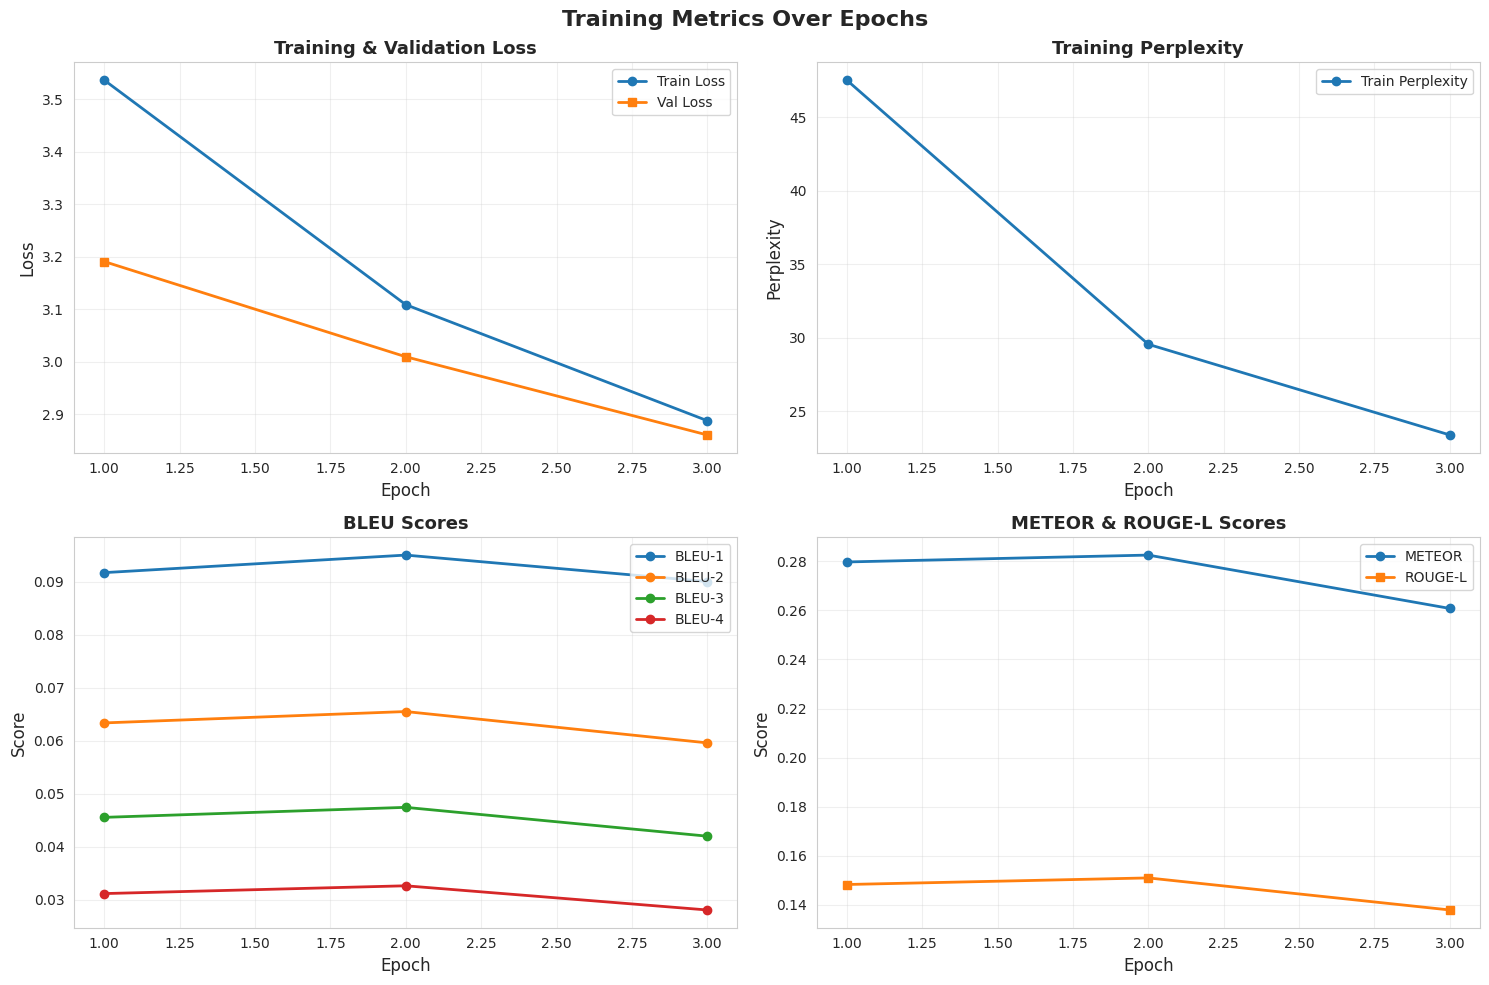

In [11]:
# Plot training metrics
print("\nGenerating visualizations...")

# 1. Training metrics (loss, perplexity, BLEU, METEOR, ROUGE)
fig1 = plot_training_metrics(
    metrics_csv=str(metrics_csv),
    save_path=str(viz_dir / 'training_metrics.png')
)
plt.show()

Learning rate plot saved to: /home/miguel/Desktop/MCIM/Projects/MCIM_Final_Project/outputs/training_runs/first_frontal_impression_20260105_135159/visualizations/learning_rate.png


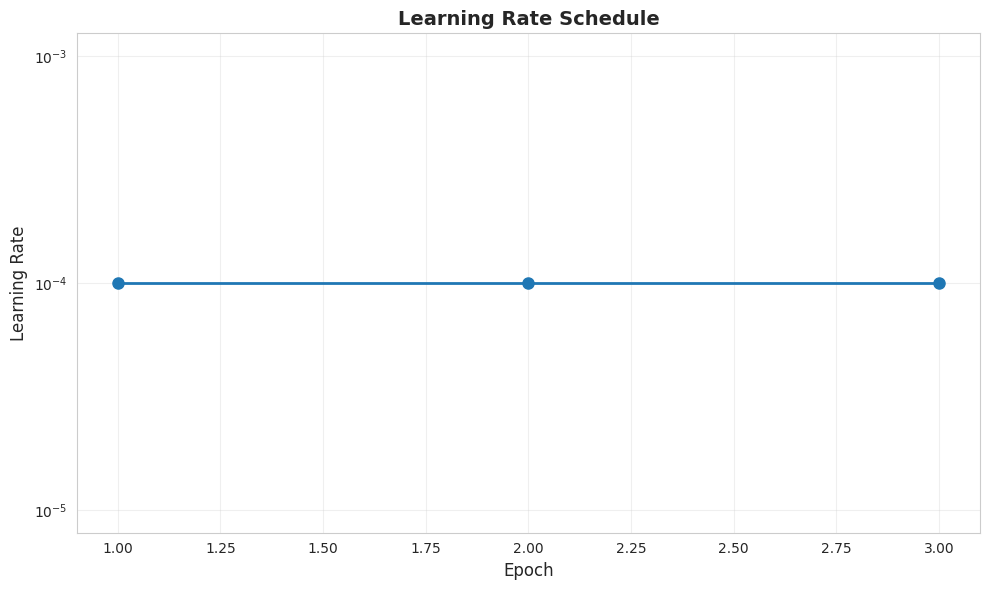

In [12]:
# 2. Learning rate schedule
fig2 = plot_learning_rate(
    metrics_csv=str(metrics_csv),
    save_path=str(viz_dir / 'learning_rate.png')
)
if fig2:
    plt.show()

Epoch time plot saved to: /home/miguel/Desktop/MCIM/Projects/MCIM_Final_Project/outputs/training_runs/first_frontal_impression_20260105_135159/visualizations/epoch_time.png


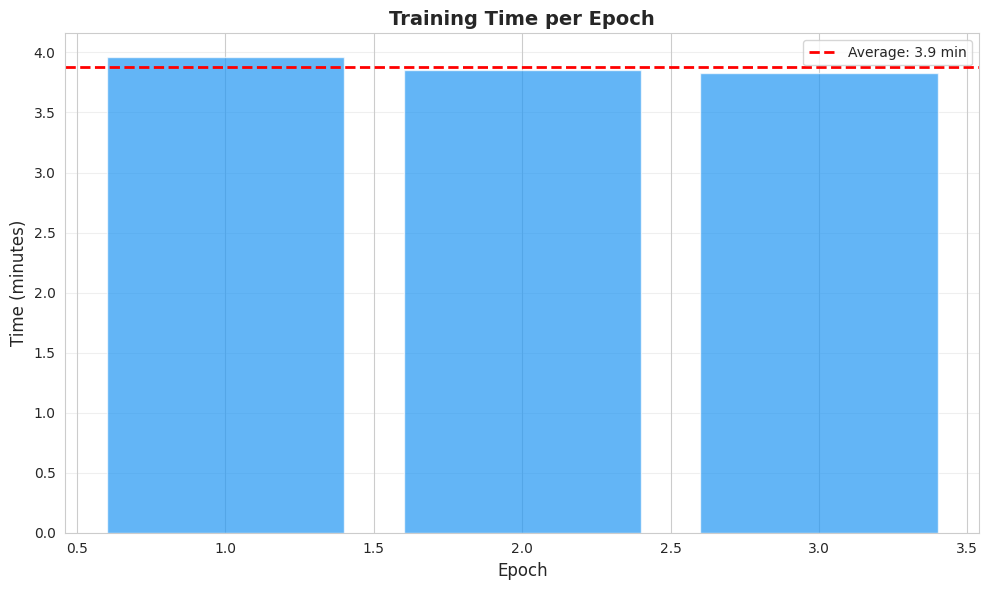

In [13]:
# 3. Epoch time
fig3 = plot_epoch_time(
    metrics_csv=str(metrics_csv),
    save_path=str(viz_dir / 'epoch_time.png')
)
if fig3:
    plt.show()

### Sample Predictions

Load and visualize sample predictions from the final epoch.

Loading samples from: epoch_003_samples.json
Loaded 10 sample predictions
Sample predictions plot saved to: /home/miguel/Desktop/MCIM/Projects/MCIM_Final_Project/outputs/training_runs/first_frontal_impression_20260105_135159/visualizations/sample_predictions.png


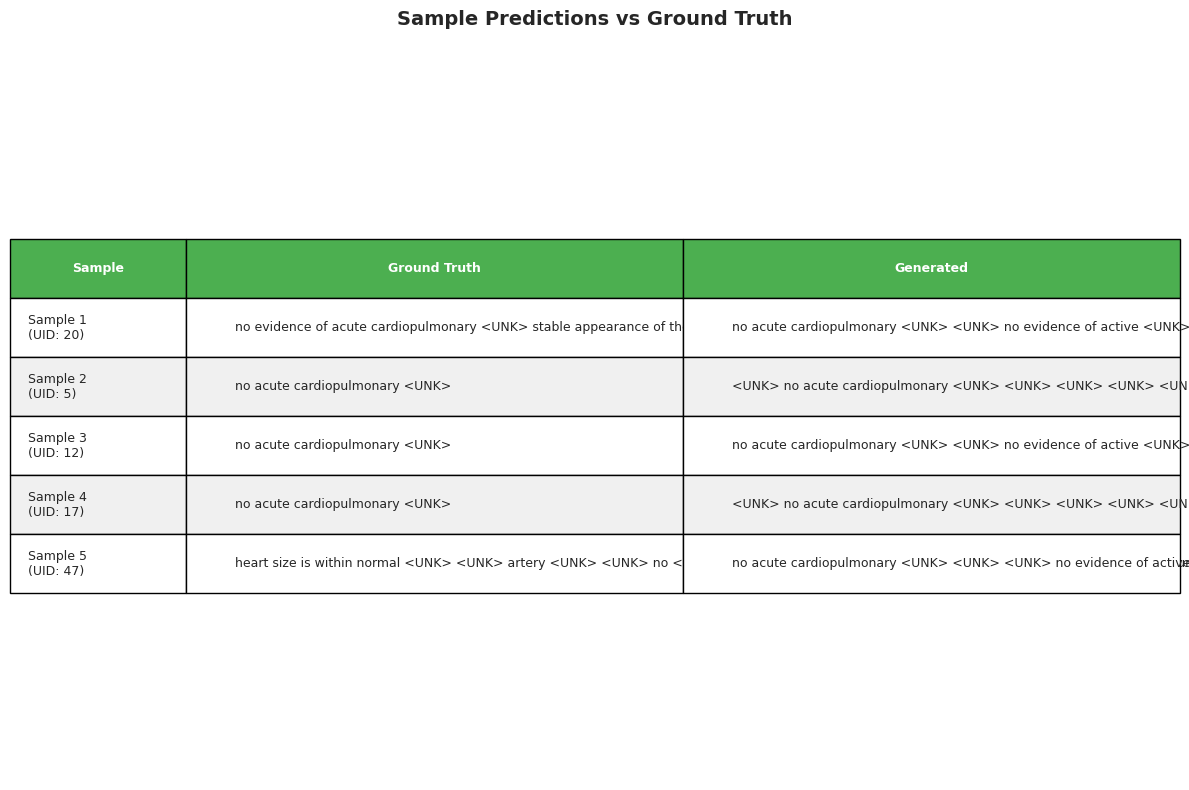


ALL SAMPLE PREDICTIONS

Sample 1 (UID: 20):
  Ground Truth: no evidence of acute cardiopulmonary <UNK> stable appearance of the <UNK>
  Generated:    no acute cardiopulmonary <UNK> <UNK> no evidence of active <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

Sample 2 (UID: 5):
  Ground Truth: no acute cardiopulmonary <UNK>
  Generated:    <UNK> no acute cardiopulmonary <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

Sample 3 (UID: 12):
  Ground Truth: no acute cardiopulmonary <UNK>
  Generated:    no acute cardiopulmonary <UNK> <UNK> no evidence of active <UNK> <UNK>

In [14]:
# Load latest sample outputs
samples_dir = trainer.output_dir / 'sample_outputs'
sample_files = sorted(samples_dir.glob('epoch_*_samples.json'))

if sample_files:
    latest_samples_file = sample_files[-1]
    print(f"Loading samples from: {latest_samples_file.name}")
    
    with open(latest_samples_file, 'r') as f:
        samples = json.load(f)
    
    print(f"Loaded {len(samples)} sample predictions")
    
    # Plot sample predictions
    fig4 = plot_sample_predictions(
        samples=samples,
        max_samples=5,
        save_path=str(viz_dir / 'sample_predictions.png')
    )
    plt.show()
    
    # Print all samples
    print("\n" + "="*70)
    print("ALL SAMPLE PREDICTIONS")
    print("="*70)
    for i, sample in enumerate(samples, 1):
        print(f"\nSample {i} (UID: {sample['uid']}):")
        print(f"  Ground Truth: {sample['reference']}")
        print(f"  Generated:    {sample['generated']}")
else:
    print("No sample outputs found")

## 9. Final Metrics

Display best model performance and final evaluation metrics.

In [15]:
# Load training manifest
manifest_path = trainer.output_dir / 'training_manifest.json'

if manifest_path.exists():
    with open(manifest_path, 'r') as f:
        manifest = json.load(f)
    
    print("=" * 70)
    print("TRAINING SUMMARY")
    print("=" * 70)
    
    # Run info
    print(f"\nRun Information:")
    print(f"  Start time: {manifest['run_info']['start_time']}")
    if 'end_time' in manifest['run_info']:
        print(f"  End time: {manifest['run_info']['end_time']}")
        print(f"  Duration: {manifest['run_info']['duration_hours']:.2f} hours")
    
    # Hardware
    print(f"\nHardware:")
    print(f"  Device: {manifest['hardware']['device']}")
    if 'gpu_name' in manifest['hardware']:
        print(f"  GPU: {manifest['hardware']['gpu_name']}")
        print(f"  Memory: {manifest['hardware']['gpu_memory_gb']:.1f} GB")
    
    # Training summary
    if 'training_summary' in manifest:
        summary = manifest['training_summary']
        print(f"\nTraining Summary:")
        print(f"  Total epochs: {summary['total_epochs']}")
        print(f"  Total steps: {summary['total_steps']}")
        if 'best_epoch' in summary and summary['best_epoch']:
            print(f"  Best epoch: {summary['best_epoch']}")
            print(f"  Best {summary['best_metric']['name']}: {summary['best_metric']['value']:.4f}")
        
        if 'final_metrics' in summary and summary['final_metrics']:
            print(f"\n  Final Validation Metrics:")
            for metric, value in summary['final_metrics'].items():
                # Display metric with appropriate formatting
                metric_name = metric.replace('val_', '').replace('_', '-').upper()
                print(f"    {metric_name}: {value:.4f}")
else:
    print("Training manifest not found")

TRAINING SUMMARY

Run Information:
  Start time: 2026-01-05T13:51:59.444057
  End time: 2026-01-05T14:03:38.973865
  Duration: 0.19 hours

Hardware:
  Device: unknown
  GPU: unknown
  Memory: 0.0 GB

Training Summary:
  Total epochs: 3
  Total steps: 2211
  Best epoch: 3
  Best val_loss: 2.8609

  Final Validation Metrics:
    BLEU-1: 0.0901
    BLEU-2: 0.0596
    BLEU-3: 0.0420
    BLEU-4: 0.0280
    METEOR: 0.2608
    ROUGE-L: 0.1379
    LOSS: 2.8609


## 11. Load Best Model for Inference (Optional)

Example of how to load the best model checkpoint for inference.

In [16]:
# Load best model checkpoint
from src.utils import CheckpointManager

checkpoint_manager = CheckpointManager(
    checkpoint_dir=str(trainer.output_dir / 'checkpoints'),
    max_checkpoints=5
)

best_checkpoint = checkpoint_manager.get_best_checkpoint()

if best_checkpoint:
    print(f"Loading best model from: {best_checkpoint}")
    
    # Create new model instance
    inference_model = EncoderDecoderModel(
        vocab_size=len(vocabulary),
        embedding_dim=config['model']['decoder']['embedding_dim'],
        encoder_feature_dim=config['model']['encoder']['output_feature_dim'],
        decoder_dim=config['model']['decoder']['hidden_dim'],
        attention_dim=config['model']['decoder']['attention']['attention_dim'],
        attention_type=config['model']['decoder']['attention']['type'],
        dropout=0.0,  # No dropout for inference
        encoder_architecture=config['model']['encoder']['architecture'],
        encoder_pretrained=False,  # Will load from checkpoint
        encoder_freeze=False
    ).to(device)
    
    # Load checkpoint
    checkpoint_info = checkpoint_manager.load_checkpoint(
        checkpoint_path=best_checkpoint,
        model=inference_model,
        device=device
    )
    
    inference_model.eval()
    
    print(f"✓ Best model loaded from epoch {checkpoint_info['epoch']}")
    print(f"  Metrics: {checkpoint_info['metrics']}")
    
    print("\nModel ready for inference!")
else:
    print("No best checkpoint found")

Loading best model from: /home/miguel/Desktop/MCIM/Projects/MCIM_Final_Project/outputs/training_runs/first_frontal_impression_20260105_135159/checkpoints/best_model.pt
✓ Best model loaded from epoch 3
  Metrics: {'loss': 2.8881018570190853, 'perplexity': 23.396637584493472, 'val_bleu_1': 0.09005434782608694, 'val_bleu_2': 0.059588876018051476, 'val_bleu_3': 0.041966811423104135, 'val_bleu_4': 0.028029142497045245, 'val_meteor': np.float64(0.26080754496260933), 'val_rouge_l': np.float64(0.13785186398721688), 'val_loss': 2.860906002962071}

Model ready for inference!


In [17]:
# Example: Generate caption for random test image
if best_checkpoint:
    # Get random test sample
    test_sample_idx = np.random.randint(0, len(test_dataset))
    image, caption, caption_length, image_path, uid = test_dataset[test_sample_idx]
    
    print(f"Generating caption for test sample {test_sample_idx} (UID: {uid}):")
    print(f"  Image: {Path(image_path).name}")
    
    # Ground truth
    ground_truth = vocabulary.decode(caption.tolist())
    print(f"\nGround Truth: {ground_truth}")
    
    # Generate caption
    image_batch = image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        generated_ids, scores = inference_model.generate_caption(
            image_batch,
            max_length=config['inference']['decoding']['max_length'],
            beam_size=config['inference']['decoding']['beam_size']
        )
    
    # Decode
    generated_caption = vocabulary.decode(generated_ids)
    print(f"Generated:    {generated_caption}")

Generating caption for test sample 109 (UID: 1380):
  Image: 1380_IM-0245-1001.dcm.png

Ground Truth: no acute cardiopulmonary <UNK>
Generated:    no acute cardiopulmonary <UNK> <UNK> <UNK> no evidence of active <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
